<a href="https://colab.research.google.com/github/Kryptera-K/NVDA-LinReg-BB-AO-Volume-Strategy/blob/main/NVDA_D1_%5B'Open_Above_LinReg'_'BB_Upper_Band_Falling'%5D_%5B'AO_Lower_Than_Level'_'AvgVol_Rising'%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt
from sklearn.linear_model import LinearRegression

# -------------------------
# Parameters
# -------------------------
symbol = "NVDA"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

# -------------------------
# Download Data
# -------------------------
df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# Linear Regression
# -------------------------
linreg_period = 14
linreg_shift = 5

def linreg(series, period):
    values = [np.nan] * len(series)
    for i in range(period - 1, len(series)):
        y = series[i - period + 1:i + 1].values.reshape(-1, 1)
        x = np.arange(period).reshape(-1, 1)
        model = LinearRegression().fit(x, y)
        values[i] = model.predict([[period - 1]])[0][0]
    return pd.Series(values, index=series.index)

df['LinReg'] = linreg(df['Close'], linreg_period)
df['Open_Above_LinReg'] = df['Open'] > df['LinReg']

# -------------------------
# Bollinger Bands
# -------------------------
bb_period = 20
bb_std = 2
bb_shift = 5

df['BB_MA'] = df['Close'].rolling(window=bb_period).mean()
df['BB_Upper'] = df['BB_MA'] + bb_std * df['Close'].rolling(window=bb_period).std()
df['BB_Upper_Band_Falling'] = df['BB_Upper'] < df['BB_Upper'].shift(bb_shift)

# -------------------------
# Awesome Oscillator
# -------------------------
def awesome_oscillator(df, short_period=5, long_period=34):
    df = df.copy()
    df["MedianPrice"] = (df["High"] + df["Low"]) / 2
    df["SMA_short"] = df["MedianPrice"].rolling(window=short_period).mean()
    df["SMA_long"] = df["MedianPrice"].rolling(window=long_period).mean()
    df["AO"] = df["SMA_short"] - df["SMA_long"]
    return df["AO"]

df["AO"] = awesome_oscillator(df)
df["AO_Lower_Than_Level"] = df["AO"] < 0

# -------------------------
# Average Volume
# -------------------------
avg_vol_period = 20
shift_volume_para = 10

df['AvgVolume'] = df['Volume'].rolling(window=avg_vol_period).mean()
df['AvgVol_Rising'] = df['AvgVolume'] > df['AvgVolume'].shift(shift_volume_para)

# -------------------------
# Signals
# -------------------------
df['entry_signal'] = df['Open_Above_LinReg'] & df['BB_Upper_Band_Falling']
df['exit_signal'] = df['AO_Lower_Than_Level'] & df['AvgVol_Rising']

# -------------------------
# Backtest
# -------------------------
entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)

print(pf.stats())
pf.plot().show()


/tmp/ipython-input-2678801090.py:18: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Start                                2000-01-03 00:00:00
End                                  2025-09-26 00:00:00
Period                                6473 days 00:00:00
Start Value                                     100000.0
End Value                               670392373.023498
Total Return [%]                           670292.373023
Benchmark Return [%]                       197304.326395
Max Gross Exposure [%]                             100.0
Total Fees Paid                          11101888.818675
Max Drawdown [%]                               82.390003
Max Drawdown Duration                 1330 days 00:00:00
Total Trades                                         108
Total Closed Trades                                  108
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   53.703704
Best Trade [%]                                226.099038
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-09-26 00:00:00
Period                         6473 days 00:00:00
Start Value                              100000.0
End Value                        197404342.842628
Total Return [%]                    197304.342843
Benchmark Return [%]                197304.342843
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        89.953261
Max Drawdown Duration          2153 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                   197304342.842628
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


In [ ]:
# -------------------------
# Parameters
# -------------------------
symbol = "NVDA"
start_date = "2020-01-01"
end_date = "2026-01-01"
interval = "1d"

# -------------------------
# Download Data
# -------------------------
df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

/tmp/ipython-input-3683837864.py:12: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


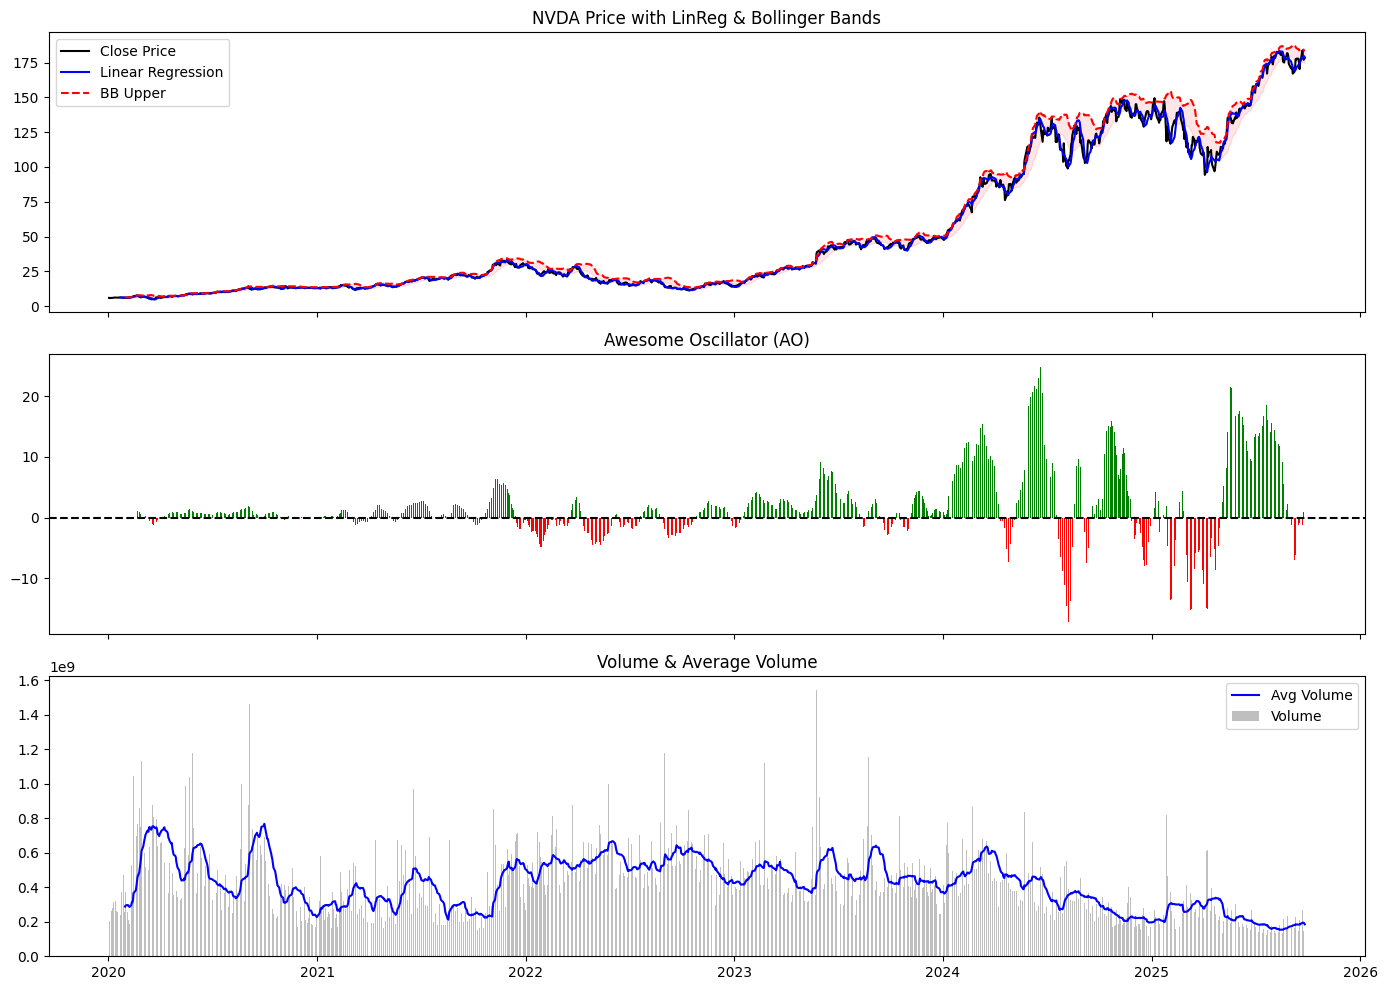

In [ ]:
import matplotlib.pyplot as plt

# -------------------------
# Plot Setup
# -------------------------
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# -------------------------
# 1. Price + LinReg + Bollinger Bands
# -------------------------
axes[0].plot(df['Close'], label='Close Price', color='black')
axes[0].plot(df['LinReg'], label='Linear Regression', color='blue')
axes[0].plot(df['BB_Upper'], label='BB Upper', color='red', linestyle='--')
axes[0].fill_between(df.index, df['BB_Upper'], df['BB_MA'], color='red', alpha=0.1)
axes[0].set_title(f'{symbol} Price with LinReg & Bollinger Bands')
axes[0].legend()

# -------------------------
# 2. Awesome Oscillator
# -------------------------
axes[1].bar(df.index, df['AO'], color=['green' if val >= 0 else 'red' for val in df['AO']])
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_title('Awesome Oscillator (AO)')

# -------------------------
# 3. Average Volume
# -------------------------
axes[2].bar(df.index, df['Volume'], label='Volume', color='gray', alpha=0.5)
axes[2].plot(df['AvgVolume'], label='Avg Volume', color='blue')
axes[2].set_title('Volume & Average Volume')
axes[2].legend()

# -------------------------
# Final Layout
# -------------------------
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Parameters
# -------------------------
symbol = "NVDA"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

bb_period = 20
bb_shift = 5
ADX_period = 14
di_shift = 5
ao_short = 5
ao_long = 34

# -------------------------
# Download Data
# -------------------------
df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# Bollinger Bands
# -------------------------
df['BB_MA'] = df['Close'].rolling(bb_period).mean()
df['BB_Upper'] = df['BB_MA'] + 2 * df['Close'].rolling(bb_period).std()
df['BB_Lower'] = df['BB_MA'] - 2 * df['Close'].rolling(bb_period).std()

# -------------------------
# DI+ / DI- Calculation
# -------------------------
df['H-L'] = df['High'] - df['Low']
df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
df['TR'] = df[['H-L','H-PC','L-PC']].max(axis=1)

df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                     np.maximum(df['High'] - df['High'].shift(1), 0), 0)
df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                     np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)

df['TR_smooth'] = df['TR'].rolling(ADX_period).sum()
df['+DM_smooth'] = df['+DM'].rolling(ADX_period).sum()
df['-DM_smooth'] = df['-DM'].rolling(ADX_period).sum()

df['DI+'] = 100 * (df['+DM_smooth'] / df['TR_smooth'])
df['DI-'] = 100 * (df['-DM_smooth'] / df['TR_smooth'])
df['ADX'] = 100 * abs(df['DI+'] - df['DI-']) / (df['DI+'] + df['DI-'])
df['ADX'] = df['ADX'].rolling(ADX_period).mean()

# -------------------------
# Bull Power
# -------------------------
ema_period = 13
df['EMA'] = df['Close'].ewm(span=ema_period, adjust=False).mean()
df['Bull_Power'] = df['High'] - df['EMA']

# -------------------------
# Awesome Oscillator
# -------------------------
df['MedianPrice'] = (df['High'] + df['Low']) / 2
df['SMA_short'] = df['MedianPrice'].rolling(ao_short).mean()
df['SMA_long'] = df['MedianPrice'].rolling(ao_long).mean()
df['AO'] = df['SMA_short'] - df['SMA_long']

# -------------------------
# Signals
# -------------------------
df['DI+_Is_Falling'] = df['DI+'] < df['DI+'].shift(di_shift)
df['ADX_Rising'] = df['ADX'].diff() > 0
df['BullP_Upward'] = df['Bull_Power'] > df['Bull_Power'].shift(1)

df['DI+_Lower_Than_DI-'] = df['DI+'] < df['DI-']
df['BB_Open_Below_Lower_after_Above'] = (df['Open'] < df['BB_Lower']) & (df['Open'].shift(bb_shift) > df['BB_Lower'].shift(bb_shift))
df['AO_Lower_Than_Level'] = df['AO'] < 0

df['entry_signal'] = df['DI+_Is_Falling'] & df['ADX_Rising'] & df['BullP_Upward']
df['exit_signal'] = df['DI+_Lower_Than_DI-'] & df['BB_Open_Below_Lower_after_Above'] & df['AO_Lower_Than_Level']

# -------------------------
# Backtest
# -------------------------
entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)

print(pf.stats())
pf.plot().show()


/tmp/ipython-input-4057220442.py:24: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Start                                 2000-01-03 00:00:00
End                                   2025-09-25 00:00:00
Period                                 6472 days 00:00:00
Start Value                                      100000.0
End Value                                322255657.244561
Total Return [%]                            322155.657245
Benchmark Return [%]                        193216.034457
Max Gross Exposure [%]                              100.0
Total Fees Paid                            3387835.893468
Max Drawdown [%]                                82.774969
Max Drawdown Duration                  2044 days 00:00:00
Total Trades                                           83
Total Closed Trades                                    82
Total Open Trades                                       1
Open Trade PnL                           129972499.267327
Win Rate [%]                                    53.658537
Best Trade [%]                                 293.759747
Worst Trade [%

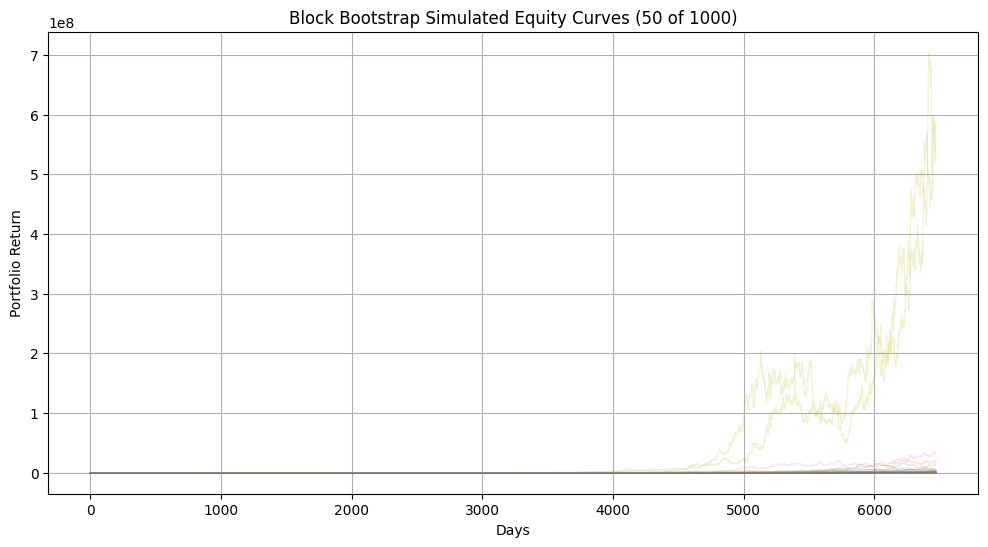

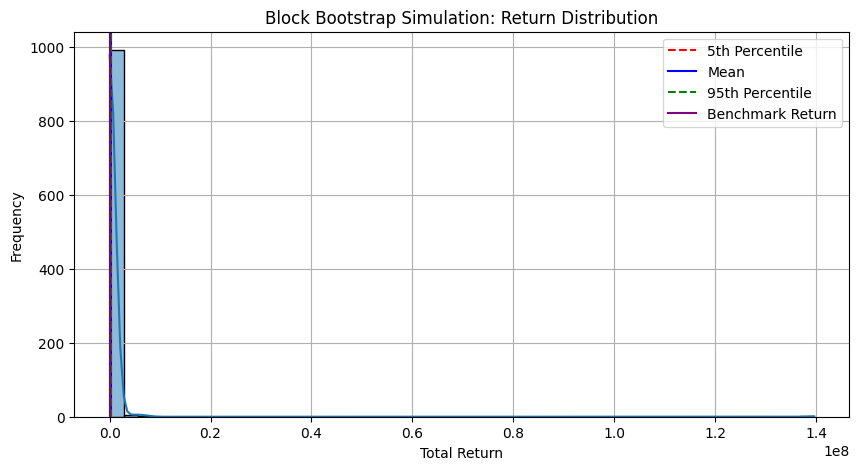

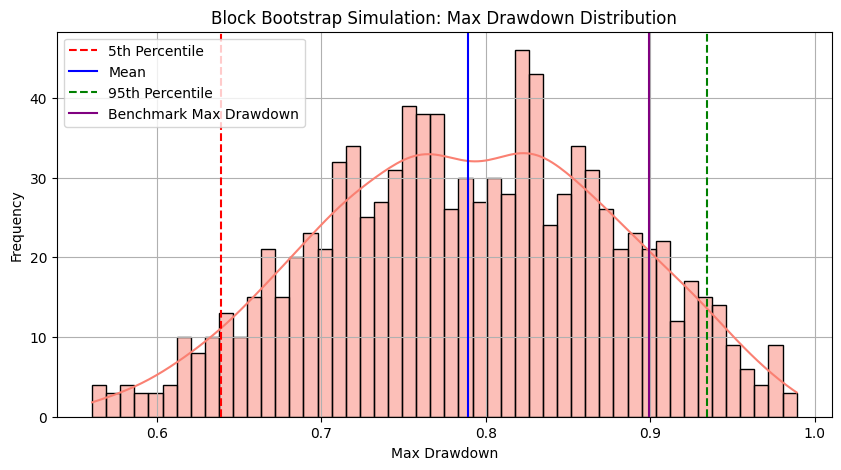

Block Bootstrap Summary (1000 Simulations):
Mean Final Return: 23965213.92%
Median Final Return: 333599.68%
5th Percentile Return: 3297.74%
95th Percentile Return: 28072466.17%
Average Max Drawdown: 78.92%
Average Sharpe Ratio: 0.83
Number of simulations with return less than benchmark: 413
Number of simulations with max drawdown greater than benchmark: 122


In [ ]:
# ------------------ Block Bootstrap MONTE CARLO SIMULATION ------------------

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Parameters
n_simulations = 1000
n_days = len(pf.returns())
init_value = 100
block_size = 5  # number of consecutive days per block

# Get daily returns from the backtest
returns = pf.returns().copy().values  # convert to numpy
n_blocks = int(np.ceil(n_days / block_size))  # number of blocks needed

# Prepare to store metrics
equity_paths = []
drawdowns = []
final_returns = []
sharpe_ratios = []
volatilities = []

# Define Benchmark Return and Max Drawdown
benchmark_return = 1932.1590
benchmark_drawdown = 0.8995

# Counters for number of simulations below benchmark return or above benchmark drawdown
below_benchmark_return_count = 0
above_benchmark_drawdown_count = 0

# Simulate full paths using Block Bootstrap
for _ in range(n_simulations):
    block_indices = np.random.randint(0, len(returns) - block_size + 1, size=n_blocks)
    sampled_returns = np.concatenate([returns[i:i+block_size] for i in block_indices])[:n_days]

    equity = init_value * np.cumprod(1 + sampled_returns)

    equity_paths.append(equity)
    daily_returns = np.diff(equity) / equity[:-1]

    max_dd = np.max(1 - equity / np.maximum.accumulate(equity))
    total_return = (equity[-1] / init_value) - 1
    volatility = np.std(daily_returns)
    sharpe = np.mean(daily_returns) / (volatility + 1e-8) * np.sqrt(252)

    drawdowns.append(max_dd)
    final_returns.append(total_return)
    volatilities.append(volatility)
    sharpe_ratios.append(sharpe)

    if total_return < benchmark_return:
        below_benchmark_return_count += 1
    if max_dd > benchmark_drawdown:
        above_benchmark_drawdown_count += 1

# Plot: Sampled equity paths
plt.figure(figsize=(12, 6))
for i in range(50):
    plt.plot(equity_paths[i], alpha=0.2, linewidth=0.8)
plt.title('Block Bootstrap Simulated Equity Curves (50 of 1000)')
plt.xlabel('Days')
plt.ylabel('Portfolio Return')
plt.grid(True)
plt.show()

# Plot: Histogram of final returns with benchmark line
plt.figure(figsize=(10, 5))
sns.histplot(final_returns, bins=50, kde=True)
plt.axvline(np.percentile(final_returns, 5), color='red', linestyle='--', label='5th Percentile')
plt.axvline(np.mean(final_returns), color='blue', linestyle='-', label='Mean')
plt.axvline(np.percentile(final_returns, 95), color='green', linestyle='--', label='95th Percentile')
plt.axvline(benchmark_return, color='purple', linestyle='-', label='Benchmark Return')
plt.title('Block Bootstrap Simulation: Return Distribution')
plt.xlabel('Total Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

# Plot: Histogram of drawdowns with benchmark line
plt.figure(figsize=(10, 5))
sns.histplot(drawdowns, bins=50, kde=True, color='salmon')
plt.axvline(np.percentile(drawdowns, 5), color='red', linestyle='--', label='5th Percentile')
plt.axvline(np.mean(drawdowns), color='blue', linestyle='-', label='Mean')
plt.axvline(np.percentile(drawdowns, 95), color='green', linestyle='--', label='95th Percentile')
plt.axvline(benchmark_drawdown, color='purple', linestyle='-', label='Benchmark Max Drawdown')
plt.title('Block Bootstrap Simulation: Max Drawdown Distribution')
plt.xlabel('Max Drawdown')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

# Show summary stats
print("Block Bootstrap Summary (1000 Simulations):")
print(f"Mean Final Return: {np.mean(final_returns):.2%}")
print(f"Median Final Return: {np.median(final_returns):.2%}")
print(f"5th Percentile Return: {np.percentile(final_returns, 5):.2%}")
print(f"95th Percentile Return: {np.percentile(final_returns, 95):.2%}")
print(f"Average Max Drawdown: {np.mean(drawdowns):.2%}")
print(f"Average Sharpe Ratio: {np.mean(sharpe_ratios):.2f}")
print(f"Number of simulations with return less than benchmark: {below_benchmark_return_count}")
print(f"Number of simulations with max drawdown greater than benchmark: {above_benchmark_drawdown_count}")